In [ ]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'ddsm-mammography:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F27069%2F46974%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241014%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241014T162552Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7bc676d22e6f872a10822541a4f518f480f0a4b31e8aa234f9c5385e1e3d7687f9e7aef40ea9ecc752c0257d7cca30691ff1dd9e54e5f92310284f941aeb6e45c5821d22b8a39ac7f6446c1535ca07ae56bbbacc44c4c5f021c447b1c4d116875f11973004973c78e2ce8c84d9e105d0735ff2f98e27305a822493a7e96bef9acddf3d1a7878df4a6121e732919cd5f825f59efe1fa80c30339d66def8814c9e6bfbe296b8bca71716e93210d03d3fb0bfdbf416d2ed43680910a0262a7b6b42a6e6798d4ab6068cf442952b62973d23c4901501593e478b719337dcba188f07dead91cdb30ed7ff525896e2944a1efabf3e45ca7dea3a949fa7123206ca4240'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 3093452937 bytes downloaded
Downloaded and uncompressed: ddsm-mammography
Data source import complete.


In [ ]:
!pip install preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 22.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.6/349.6 kB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 60.4 MB/s eta 0:00:00
  Created wheel for nltk: filename=nltk-3.2.4-py3-none-any.whl size=1367706 sha256=f0da15e26fb8de31e385683f7a5887d2cf128935f48d043a160380689767d6e8
  Stored in directory: /root/.cache/pip/wheels/0e/8c/42/bcd0934b61ecf4cef964ccc9881888cca0841ec72266e99de1
Successfully built nltk
  Attempting uninstall: nltk
    Found existing installation: nltk 3.8.1
    Uninstalling nltk-3.8.1:
      Successfully uninstalled nltk-3.8.1


In [ ]:
from collections import Counter
import cv2
import os
import glob
import skimage
import numpy as np
import pandas as pd
import seaborn as sn
import preprocessing # This line imports the preprocessing package
from tqdm import tqdm
from io import BytesIO
from PIL import Image
from os import listdir
import matplotlib.pyplot as plt
from imageio import imread
from skimage.transform import resize
from collections import Counter
import IPython.display as display

sn.set()

from sklearn.svm import SVC # SVC
from sklearn import metrics
from sklearn.utils import shuffle
from xgboost import XGBClassifier # XGBClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import compute_class_weight
from sklearn.preprocessing import MinMaxScaler,LabelBinarizer
from sklearn.ensemble import AdaBoostClassifier # AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier # KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier # RandomForestClassifier
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16 # VGG16
from tensorflow.keras.applications.vgg19 import VGG19 # VGG19
from tensorflow.keras.applications.resnet50 import ResNet50 # ResNet50
from tensorflow.keras.applications.xception import Xception # Xception
from tensorflow.keras.applications.mobilenet import MobileNet # MobileNet
from tensorflow.keras.applications.nasnet import NASNetMobile # NASNetMobile
from tensorflow.keras.applications.densenet import DenseNet169 # DenseNet169
from tensorflow.keras.applications.densenet import DenseNet121 # DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 # MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3 # InceptionV3
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Flatten, Activation, GlobalAveragePooling2D,Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
images=[]
labels=[]
feature_dictionary = {
    'label': tf.io.FixedLenFeature([], tf.int64),
    'label_normal': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string)
    }

In [ ]:
def _parse_function(example, feature_dictionary=feature_dictionary):
    parsed_example = tf.io.parse_example(example, feature_dictionary)
    return parsed_example

def read_data(filename):
    full_dataset = tf.data.TFRecordDataset(filename,num_parallel_reads=tf.data.experimental.AUTOTUNE)
    full_dataset = full_dataset.shuffle(buffer_size=31000)
    full_dataset = full_dataset.cache()
    print("Size of Training Dataset: ", len(list(full_dataset)))

    feature_dictionary = {
    'label': tf.io.FixedLenFeature([], tf.int64),
    'label_normal': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string)
    }

    full_dataset = full_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    print(full_dataset)
    for image_features in full_dataset:
        image = image_features['image'].numpy()
        image = tf.io.decode_raw(image_features['image'], tf.uint8)
        image = tf.reshape(image, [299, 299,1])
        image=image.numpy()
        image=cv2.resize(image,(100,100))
#         image=cv2.merge([image,image,image])
        #plt.imshow(image)
        images.append(image)
        labels.append(image_features['label_normal'].numpy())

In [ ]:
filenames=['../input/ddsm-mammography/training10_0/training10_0.tfrecords',
          '../input/ddsm-mammography/training10_1/training10_1.tfrecords',
          '../input/ddsm-mammography/training10_2/training10_2.tfrecords',
          '../input/ddsm-mammography/training10_3/training10_3.tfrecords',
          '../input/ddsm-mammography/training10_4/training10_4.tfrecords']

for file in filenames:
    read_data(file)

print(len(images))
print(len(labels))

Size of Training Dataset:  11177
<_ParallelMapDataset element_spec={'image': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'label_normal': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
Size of Training Dataset:  11177
<_ParallelMapDataset element_spec={'image': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'label_normal': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
Size of Training Dataset:  11177
<_ParallelMapDataset element_spec={'image': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'label_normal': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
Size of Training Dataset:  11177
<_ParallelMapDataset element_spec={'image': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'label_normal': TensorSpec(shape=(), dtype=tf.int64, name=None

In [ ]:
X=np.array(images)
y=np.array(labels)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2021,shuffle=True,stratify=y)
(a,b,c)=x_train.shape
x_train = np.reshape(x_train, (a, b, c, 1))
(a, b, c)=x_test.shape
x_test = np.reshape(x_test, (a, b, c, 1))

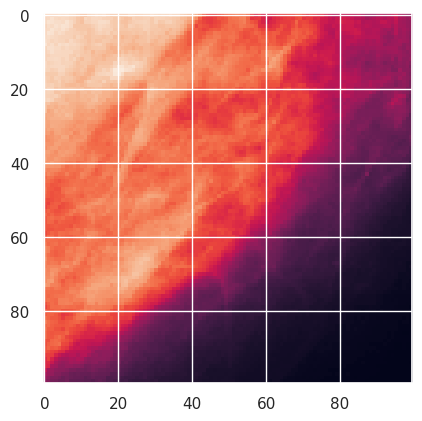

In [ ]:
plt.imshow(x_train[0])

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPool2D, Flatten
from keras import optimizers
from keras import losses
from sklearn import metrics

print(x_train[0].shape)

(100, 100, 1)


In [ ]:
rows, cols,color = x_train[0].shape
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='valid', strides=(1, 1),input_shape=(rows,cols,1)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', strides=(1, 1)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2),strides=2))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same', strides=(1, 1)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2),strides=2))

model.add(Conv2D(32, (3, 3), padding='same', strides=(1, 1)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2),strides=2))

model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 98, 98, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 98, 98, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 49, 49, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 49, 49, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 49, 49, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 12, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           1,153 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 75,361 (294.38 KB)

 Trainable params: 75,361 (294.38 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', patience=6,restore_best_weights=True, verbose=1)

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train,validation_split=0.2,shuffle=True, epochs=40, batch_size=64,callbacks=[es])
loss_value , accuracy = model.evaluate(x_test, y_test)

print('Test_loss_value = ' +str(loss_value))
print('test_accuracy = ' + str(accuracy))

#print(model.predict(x_test))
#model.save('breast_cance_model.h5')

# save_dictionary('history1.dat', history.history)

Epoch 1/40
559/559 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - accuracy: 0.8545 - loss: 0.6274 - val_accuracy: 0.8664 - val_loss: 0.3339
Epoch 2/40
559/559 ━━━━━━━━━━━━━━━━━━━━ 30s 17ms/step - accuracy: 0.8729 - loss: 0.3139 - val_accuracy: 0.8688 - val_loss: 0.2871
Epoch 3/40
559/559 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.8750 - loss: 0.2873 - val_accuracy: 0.8797 - val_loss: 0.2653
Epoch 4/40
559/559 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.8923 - loss: 0.2547 - val_accuracy: 0.8910 - val_loss: 0.2382
Epoch 5/40
559/559 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.8995 - loss: 0.2404 - val_accuracy: 0.8887 - val_loss: 0.2505
Epoch 6/40
559/559 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.9044 - loss: 0.2290 - val_accuracy: 0.9087 - val_loss: 0.2172
Epoch 7/40
559/559 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.9064 - loss: 0.2237 - val_accuracy: 0.9056 - val_loss: 0.2093
Epoch 8/40
559/559 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.9125 - loss: 0.2121 - 

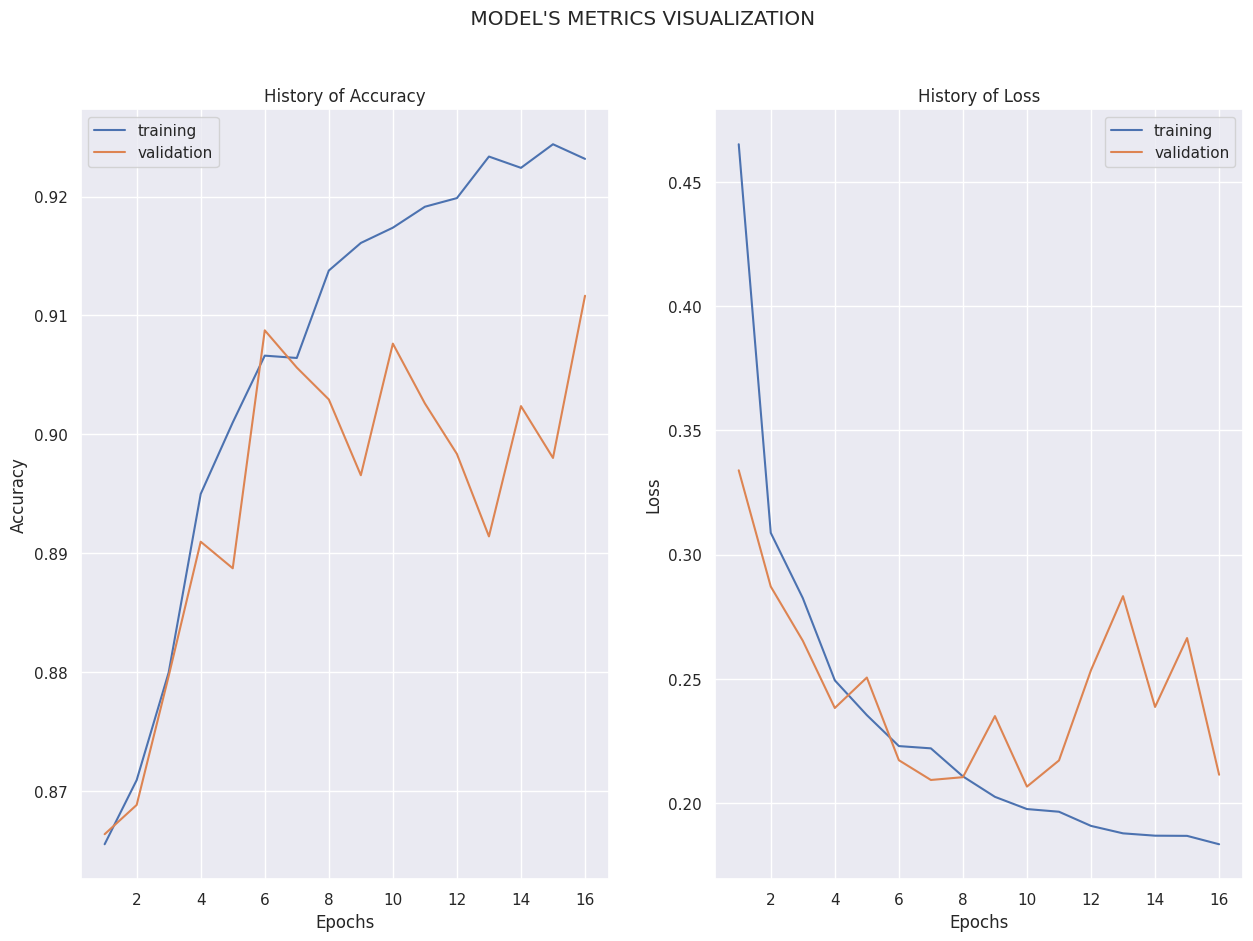

In [ ]:
import matplotlib.pyplot as plt
def Train_Val_Plot(acc,val_acc,loss,val_loss):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,10))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    plt.show()


Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'])

In [ ]:
import numpy as np # Import numpy for argmax

y_pred = np.argmax(model.predict(x_test), axis=-1) # Use predict and argmax for multi-class
y_pred_prb = model.predict(x_test) # predict_proba is replaced by predict in recent versions

350/350 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [ ]:
target=["0","1"]
from sklearn import metrics
print('Accuracy:', np.round(metrics.accuracy_score(y_test, y_pred),4))
print('Precision:', np.round(metrics.precision_score(y_test, y_pred, average='weighted'),4))
print('Recall:', np.round(metrics.recall_score(y_test,y_pred, average='weighted'),4))
print('F1 Score:', np.round(metrics.f1_score(y_test, y_pred, average='weighted'),4))
print('ROC AUC Score:', np.round(metrics.roc_auc_score(y_test, y_pred_prb,multi_class='ovo', average='weighted'),4))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test, y_pred),4))
print('\t\tClassification Report:\n', metrics.classification_report(y_test, y_pred,target_names=target))

Accuracy: 0.8696
Precision: 0.7561
Recall: 0.8696
F1 Score: 0.8089
ROC AUC Score: 0.9469
Cohen Kappa Score: 0.0
		Classification Report:
               precision    recall  f1-score   support

           0       0.87      1.00      0.93      9719
           1       0.00      0.00      0.00      1458

    accuracy                           0.87     11177
   macro avg       0.43      0.50      0.47     11177
weighted avg       0.76      0.87      0.81     11177



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Breast Cancer VGG-16 Features

In [ ]:
from collections import Counter
import cv2
import os
import glob
import skimage
import numpy as np
import pandas as pd
import seaborn as sn
import preprocessing
from tqdm import tqdm
from PIL import Image
from os import listdir
import matplotlib.pyplot as plt
from skimage.transform import resize
from collections import Counter

sn.set()
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC # SVC
from sklearn import metrics
from sklearn.utils import shuffle
from xgboost import XGBClassifier # XGBClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,f1_score,recall_score,cohen_kappa_score,precision_score
from sklearn.utils import compute_class_weight
from sklearn.preprocessing import MinMaxScaler,LabelBinarizer
from sklearn.ensemble import AdaBoostClassifier # AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier # KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier # RandomForestClassifier
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16 # VGG16
from tensorflow.keras.applications.vgg19 import VGG19 # VGG19
from tensorflow.keras.applications.resnet50 import ResNet50 # ResNet50
from tensorflow.keras.applications.xception import Xception # Xception
from tensorflow.keras.applications.mobilenet import MobileNet # MobileNet
from tensorflow.keras.applications.nasnet import NASNetMobile # NASNetMobile
from tensorflow.keras.applications.densenet import DenseNet169 # DenseNet169
from tensorflow.keras.applications.densenet import DenseNet121 # DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 # MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3 # InceptionV3
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Flatten, Activation, GlobalAveragePooling2D,Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
images=[]
labels=[]
feature_dictionary = {
    'label': tf.io.FixedLenFeature([], tf.int64),
    'label_normal': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string)
    }

In [ ]:
def _parse_function(example, feature_dictionary=feature_dictionary):
    parsed_example = tf.io.parse_example(example, feature_dictionary)
    return parsed_example

def read_data(filename):
    full_dataset = tf.data.TFRecordDataset(filename,num_parallel_reads=tf.data.experimental.AUTOTUNE)
    full_dataset = full_dataset.shuffle(buffer_size=31000)
    full_dataset = full_dataset.cache()
    print("Size of Training Dataset: ", len(list(full_dataset)))

    feature_dictionary = {
    'label': tf.io.FixedLenFeature([], tf.int64),
    'label_normal': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string)
    }

    full_dataset = full_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    print(full_dataset)
    for image_features in full_dataset:
        image = image_features['image'].numpy()
        image = tf.io.decode_raw(image_features['image'], tf.uint8)
        image = tf.reshape(image, [299, 299])
        image=image.numpy()
        image=cv2.resize(image,(100,100))
        image=cv2.merge([image,image,image])
        #plt.imshow(image)
        images.append(image)
        labels.append(image_features['label_normal'].numpy())

In [ ]:
filenames=['../input/ddsm-mammography/training10_0/training10_0.tfrecords',
#           '../input/ddsm-mammography/training10_1/training10_1.tfrecords',
#           '../input/ddsm-mammography/training10_2/training10_2.tfrecords',
#           '../input/ddsm-mammography/training10_3/training10_3.tfrecords',
#           '../input/ddsm-mammography/training10_4/training10_4.tfrecords']
          ]

for file in filenames:
    read_data(file)

print(len(images))
print(len(labels))

Size of Training Dataset:  11177
<_ParallelMapDataset element_spec={'image': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'label_normal': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
11177
11177


In [ ]:
X=np.array(images)
y=np.array(labels)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2021,shuffle=True)

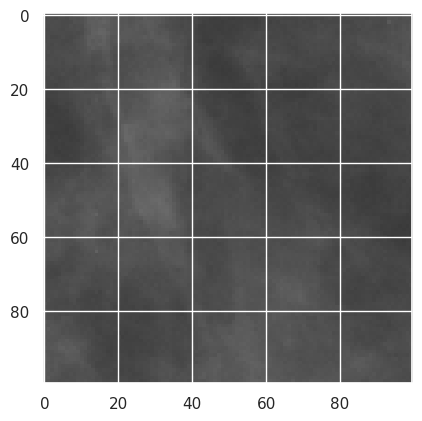

In [ ]:
plt.imshow(x_train[0])

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPool2D, Flatten
from keras import optimizers
from keras import losses
from sklearn import metrics

print(x_train[0].shape)

(100, 100, 3)


In [ ]:
rows, cols,color = x_train[0].shape
print(x_train[0].shape)

base_model = VGG16(input_shape=(100,100,3), weights='imagenet', include_top=False)
x = base_model.output
x = Dropout(0.2)(x)
predictions = Flatten()(x)

model_feat = Model(inputs=base_model.input,outputs=predictions)

train_features = model_feat.predict(x_train)
test_features=model_feat.predict(x_test)

(100, 100, 3)
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
280/280 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step


In [ ]:
x_train_acc, x_val_acc, y_train_acc, y_val_acc = train_test_split(train_features,y_train,
                                                  test_size = 0.2,
                                                  stratify = y_train,
                                                  shuffle = True,
                                                  random_state = 42)
X_test,y_test=test_features,y_test

In [ ]:
print('length X_train:', len(x_train_acc))
print('length y_train:', len(y_train_acc))

print('length X_val:',  len(x_val_acc))
print('length y_val:', len(y_val_acc))

print('length X_test:',  len(X_test))
print('length y_test:', len(y_test))

length X_train: 7152
length y_train: 7152
length X_val: 1789
length y_val: 1789
length X_test: 2236
length y_test: 2236


In [ ]:
names = [
        "K Nearest Neighbour Classifier",
        'SVM',
        "Random Forest Classifier",
        "AdaBoost Classifier",
        "XGB Classifier",
         ]
classifiers = [
    KNeighborsClassifier(),
    SVC(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    XGBClassifier(),
        ]

zipped_clf = zip(names,classifiers)

In [ ]:
def classifier_summary(pipeline, X_train, y_train, X_val, y_val,X_test,y_test):
    sentiment_fit = pipeline.fit(X_train, y_train)

    y_pred_train= sentiment_fit.predict(X_train)
    y_pred_val = sentiment_fit.predict(X_val)
    y_pred_test = sentiment_fit.predict(X_test)

    train_accuracy = np.round(accuracy_score(y_train, y_pred_train),4)*100
    train_precision = np.round(precision_score(y_train, y_pred_train, average='weighted'),4)
    train_recall = np.round(recall_score(y_train, y_pred_train, average='weighted'),4)
    train_F1 = np.round(f1_score(y_train, y_pred_train, average='weighted'),4)
    train_kappa =  np.round(cohen_kappa_score(y_train, y_pred_train),4)
    train_confusion_matrix = confusion_matrix(y_train,y_pred_train)

    val_accuracy = np.round(accuracy_score(y_val, y_pred_val),4)*100
    val_precision = np.round(precision_score(y_val, y_pred_val, average='weighted'),4)
    val_recall = np.round(recall_score(y_val, y_pred_val, average='weighted'),4)
    val_F1 = np.round(f1_score(y_val, y_pred_val, average='weighted'),4)
    val_kappa =  np.round(cohen_kappa_score(y_val, y_pred_val),4)
    val_confusion_matrix = confusion_matrix(y_val,y_pred_val)

    test_accuracy = np.round(accuracy_score(y_test, y_pred_test),4)*100
    test_precision = np.round(precision_score(y_test, y_pred_test, average='weighted'),4)
    test_recall = np.round(recall_score(y_test, y_pred_test, average='weighted'),4)
    test_F1 = np.round(f1_score(y_test, y_pred_test, average='weighted'),4)
    test_kappa =  np.round(cohen_kappa_score(y_test, y_pred_test),4)
    test_confusion_matrix = confusion_matrix(y_test,y_pred_test)


    print()
    print('------------------------ Train Set Metrics------------------------')
    print()
    print("accuracy : {}%".format(train_accuracy))
    print("F1_score : {}".format(train_F1))
    print("Cohen Kappa Score : {} ".format(train_kappa))
    print("Recall : {}".format(train_recall))
    print("Precision : {}".format(train_precision))
    print("Confusion Matrix :\n {}".format(train_confusion_matrix))

    print()
    print('------------------------ Validation Set Metrics------------------------')
    print()
    print("accuracy : {}%".format(val_accuracy))
    print("F1_score : {}".format(val_F1))
    print("Cohen Kappa Score : {} ".format(val_kappa))
    print("Recall : {}".format(val_recall))
    print("Precision : {}".format(val_precision))
    print("Confusion Matrix :\n {}".format(val_confusion_matrix))

    print()
    print('------------------------ Test Set Metrics------------------------')
    print()
    print("accuracy : {}%".format(test_accuracy))
    print("F1_score : {}".format(test_F1))
    print("Cohen Kappa Score : {} ".format(test_kappa))
    print("Recall : {}".format(test_recall))
    print("Precision : {}".format(test_precision))
    print("Confusion Matrix : {}".format(test_confusion_matrix))

    print("-"*80)
    print()

In [ ]:
def classifier_comparator(X_train,y_train,X_val,y_val,X_test,y_test,classifier=zipped_clf):
    result = []
    for n,c in classifier:
        checker_pipeline = Pipeline([('classifier', c)])
        print("Fitting {} on features ".format(n))
        #print(c)
        classifier_summary(checker_pipeline,X_train, y_train, X_val, y_val,X_test,y_test)

In [ ]:
classifier_comparator(x_train_acc,y_train_acc,x_val_acc,y_val_acc,X_test,y_test,classifier=zipped_clf)

Fitting K Nearest Neighbour Classifier on features 

------------------------ Train Set Metrics------------------------

accuracy : 88.83%
F1_score : 0.8523
Cohen Kappa Score : 0.2528 
Recall : 0.8883
Precision : 0.8954
Confusion Matrix :
 [[6196    8]
 [ 791  157]]

------------------------ Validation Set Metrics------------------------

accuracy : 87.7%
F1_score : 0.8328
Cohen Kappa Score : 0.1483 
Recall : 0.877
Precision : 0.8671
Confusion Matrix :
 [[1546    6]
 [ 214   23]]

------------------------ Test Set Metrics------------------------

accuracy : 87.52%
F1_score : 0.8267
Cohen Kappa Score : 0.107 
Recall : 0.8752
Precision : 0.8661
Confusion Matrix : [[1937    5]
 [ 274   20]]
--------------------------------------------------------------------------------

Fitting SVM on features 

------------------------ Train Set Metrics------------------------

accuracy : 93.53%
F1_score : 0.9265
Cohen Kappa Score : 0.649 
Recall : 0.9353
Precision : 0.9383
Confusion Matrix :
 [[6194   

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



------------------------ Train Set Metrics------------------------

accuracy : 89.99000000000001%
F1_score : 0.8921
Cohen Kappa Score : 0.5004 
Recall : 0.8999
Precision : 0.8899
Confusion Matrix :
 [[5990  214]
 [ 502  446]]

------------------------ Validation Set Metrics------------------------

accuracy : 87.53%
F1_score : 0.8661
Cohen Kappa Score : 0.3814 
Recall : 0.8753
Precision : 0.8611
Confusion Matrix :
 [[1475   77]
 [ 146   91]]

------------------------ Test Set Metrics------------------------

accuracy : 87.12%
F1_score : 0.8618
Cohen Kappa Score : 0.3583 
Recall : 0.8712
Precision : 0.8564
Confusion Matrix : [[1840  102]
 [ 186  108]]
--------------------------------------------------------------------------------

Fitting XGB Classifier on features 

------------------------ Train Set Metrics------------------------

accuracy : 100.0%
F1_score : 1.0
Cohen Kappa Score : 1.0 
Recall : 1.0
Precision : 1.0
Confusion Matrix :
 [[6204    0]
 [   0  948]]

------------------

In [ ]:
ann=Sequential()
ann.add(Dense(16,activation='relu',input_shape=x_train_acc[0].shape))
ann.add(Dense(32,activation='relu'))
ann.add(Dense(64,activation='relu'))
ann.add(Dense(64,activation='relu'))
ann.add(Dense(32,activation='relu'))
ann.add(Dense(16,activation='relu'))
ann.add(Dense(1,activation='sigmoid'))

ann.summary()

ann.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

history = ann.fit(x_train_acc, y_train_acc,validation_data=(x_val_acc,y_val_acc), epochs=20)

loss_value , accuracy = ann.evaluate(x_train_acc, y_train_acc)
print('Train_accuracy = ' + str(accuracy))
loss_value , accuracy = ann.evaluate(x_val_acc, y_val_acc)
print('Validation_accuracy = ' + str(accuracy))
loss_value , accuracy = ann.evaluate(X_test, y_test)
print('test_accuracy = ' + str(accuracy))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                      │ (None, 16)                  │          73,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 83,185 (324.94 KB)

 Trainable params: 83,185 (324.94 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8448 - loss: 0.4025 - val_accuracy: 0.8944 - val_loss: 0.2886
Epoch 2/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8957 - loss: 0.2589 - val_accuracy: 0.8983 - val_loss: 0.2830
Epoch 3/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9170 - loss: 0.2160 - val_accuracy: 0.8513 - val_loss: 0.3359
Epoch 4/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9260 - loss: 0.1894 - val_accuracy: 0.8949 - val_loss: 0.2695
Epoch 5/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9379 - loss: 0.1582 - val_accuracy: 0.8932 - val_loss: 0.3515
Epoch 6/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9392 - loss: 0.1449 - val_accuracy: 0.8994 - val_loss: 0.3170
Epoch 7/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9538 - loss: 0.1128 - val_accuracy: 0.8854 - val_loss: 0.3437
Epoch 8/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9571 - loss: 0.1049 - val_accuracy: 0

In [ ]:
y_pred = (ann.predict(X_test) > 0.5).astype("int32")  # Replacing predict_classes with predict and thresholding for binary classification
target=["B","M"]
print('Accuracy:', np.round(metrics.accuracy_score(y_test, y_pred),4))
print('Precision:', np.round(metrics.precision_score(y_test, y_pred, average='weighted'),4))
print('Recall:', np.round(metrics.recall_score(y_test,y_pred, average='weighted'),4))
print('F1 Score:', np.round(metrics.f1_score(y_test, y_pred, average='weighted'),4))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test, y_pred),4))
print('\t\tClassification Report:\n', metrics.classification_report(y_test, y_pred,target_names=target))

70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Accuracy: 0.873
Precision: 0.868
Recall: 0.873
F1 Score: 0.8703
Cohen Kappa Score: 0.4205
		Classification Report:
               precision    recall  f1-score   support

           B       0.92      0.93      0.93      1942
           M       0.52      0.47      0.49       294

    accuracy                           0.87      2236
   macro avg       0.72      0.70      0.71      2236
weighted avg       0.87      0.87      0.87      2236



 Breast Cancer ResNet-50 Features



In [ ]:
from collections import Counter
import cv2
import os
import glob
import skimage
import numpy as np
import pandas as pd
import seaborn as sn
import preprocessing
from tqdm import tqdm
from PIL import Image
from os import listdir
import matplotlib.pyplot as plt
from skimage.transform import resize
from collections import Counter

sn.set()
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC # SVC
from sklearn import metrics
from sklearn.utils import shuffle
from xgboost import XGBClassifier # XGBClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,f1_score,recall_score,cohen_kappa_score,precision_score
from sklearn.utils import compute_class_weight
from sklearn.preprocessing import MinMaxScaler,LabelBinarizer
from sklearn.ensemble import AdaBoostClassifier # AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier # KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier # RandomForestClassifier
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16 # VGG16
from tensorflow.keras.applications.vgg19 import VGG19 # VGG19
from tensorflow.keras.applications.resnet50 import ResNet50 # ResNet50
from tensorflow.keras.applications.xception import Xception # Xception
from tensorflow.keras.applications.mobilenet import MobileNet # MobileNet
from tensorflow.keras.applications.nasnet import NASNetMobile # NASNetMobile
from tensorflow.keras.applications.densenet import DenseNet169 # DenseNet169
from tensorflow.keras.applications.densenet import DenseNet121 # DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 # MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3 # InceptionV3
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Flatten, Activation, GlobalAveragePooling2D,Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
images=[]
labels=[]
feature_dictionary = {
    'label': tf.io.FixedLenFeature([], tf.int64),
    'label_normal': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string)
    }

In [ ]:
def _parse_function(example, feature_dictionary=feature_dictionary):
    parsed_example = tf.io.parse_example(example, feature_dictionary)
    return parsed_example

def read_data(filename):
    full_dataset = tf.data.TFRecordDataset(filename,num_parallel_reads=tf.data.experimental.AUTOTUNE)
    full_dataset = full_dataset.shuffle(buffer_size=31000)
    full_dataset = full_dataset.cache()
    print("Size of Training Dataset: ", len(list(full_dataset)))

    feature_dictionary = {
    'label': tf.io.FixedLenFeature([], tf.int64),
    'label_normal': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string)
    }

    full_dataset = full_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    print(full_dataset)
    for image_features in full_dataset:
        image = image_features['image'].numpy()
        image = tf.io.decode_raw(image_features['image'], tf.uint8)
        image = tf.reshape(image, [299, 299])
        image=image.numpy()
        image=cv2.resize(image,(100,100))
        image=cv2.merge([image,image,image])
        #plt.imshow(image)
        images.append(image)
        labels.append(image_features['label_normal'].numpy())

In [ ]:
filenames=['../input/ddsm-mammography/training10_0/training10_0.tfrecords',
#          '../input/ddsm-mammography/training10_1/training10_1.tfrecords',
#           '../input/ddsm-mammography/training10_2/training10_2.tfrecords',
#           '../input/ddsm-mammography/training10_3/training10_3.tfrecords',
#           '../input/ddsm-mammography/training10_4/training10_4.tfrecords']
          ]

for file in filenames:
    read_data(file)

print(len(images))
print(len(labels))

Size of Training Dataset:  11177
<_ParallelMapDataset element_spec={'image': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'label_normal': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
11177
11177


In [ ]:
X=np.array(images)
y=np.array(labels)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2021,shuffle=True)

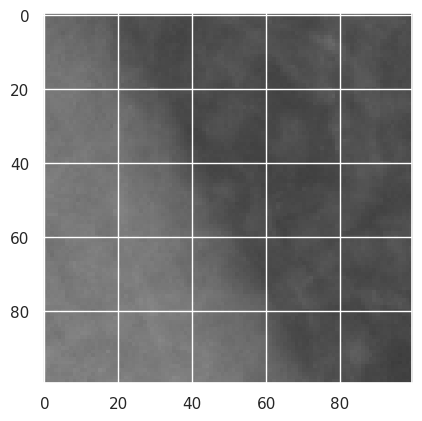

In [ ]:
plt.imshow(x_train[0])

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPool2D, Flatten
from keras import optimizers
from keras import losses
from sklearn import metrics

print(x_train[0].shape)

(100, 100, 3)


In [ ]:
rows, cols,color = x_train[0].shape
print(x_train[0].shape)

base_model = ResNet50(input_shape=(100,100,3), weights='imagenet', include_top=False)
x = base_model.output
x = Flatten()(x)
predictions = Dropout(0.5)(x)
# x = BatchNormalization()(x)
# x = Dense(128,kernel_initializer='he_uniform')(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
# x =  Dropout(0.2)(x)

# predictions = Dense(8, activation='softmax')(x)
model_feat = Model(inputs=base_model.input,outputs=predictions)

train_features = model_feat.predict(x_train)
test_features=model_feat.predict(x_test)

(100, 100, 3)
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 17s 51ms/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step


In [ ]:
train_features[0].shape

(32768,)

In [ ]:
x_train_acc, x_val_acc, y_train_acc, y_val_acc = train_test_split(train_features,y_train,
                                                  test_size = 0.3,
                                                  stratify = y_train,
                                                  shuffle = True,
                                                  random_state = 42)
X_test,y_test=test_features,y_test

In [ ]:
print('length X_train:', len(x_train_acc))
print('length y_train:', len(y_train_acc))

print('length X_val:',  len(x_val_acc))
print('length y_val:', len(y_val_acc))

print('length X_test:',  len(X_test))
print('length y_test:', len(y_test))

length X_train: 5476
length y_train: 5476
length X_val: 2347
length y_val: 2347
length X_test: 3354
length y_test: 3354


In [ ]:
names = [
        "K Nearest Neighbour Classifier",
        'SVM',
        "Random Forest Classifier",
        "AdaBoost Classifier",
        "XGB Classifier",
         ]
classifiers = [
    KNeighborsClassifier(),
    SVC(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    XGBClassifier(),
        ]

zipped_clf = zip(names,classifiers)

In [ ]:
def classifier_summary(pipeline, X_train, y_train, X_val, y_val,X_test,y_test):
    sentiment_fit = pipeline.fit(X_train, y_train)

    y_pred_train= sentiment_fit.predict(X_train)
    y_pred_val = sentiment_fit.predict(X_val)
    y_pred_test = sentiment_fit.predict(X_test)

    train_accuracy = np.round(accuracy_score(y_train, y_pred_train),4)*100
    train_precision = np.round(precision_score(y_train, y_pred_train, average='weighted'),4)
    train_recall = np.round(recall_score(y_train, y_pred_train, average='weighted'),4)
    train_F1 = np.round(f1_score(y_train, y_pred_train, average='weighted'),4)
    train_kappa =  np.round(cohen_kappa_score(y_train, y_pred_train),4)
    train_confusion_matrix = confusion_matrix(y_train,y_pred_train)

    val_accuracy = np.round(accuracy_score(y_val, y_pred_val),4)*100
    val_precision = np.round(precision_score(y_val, y_pred_val, average='weighted'),4)
    val_recall = np.round(recall_score(y_val, y_pred_val, average='weighted'),4)
    val_F1 = np.round(f1_score(y_val, y_pred_val, average='weighted'),4)
    val_kappa =  np.round(cohen_kappa_score(y_val, y_pred_val),4)
    val_confusion_matrix = confusion_matrix(y_val,y_pred_val)

    test_accuracy = np.round(accuracy_score(y_test, y_pred_test),4)*100
    test_precision = np.round(precision_score(y_test, y_pred_test, average='weighted'),4)
    test_recall = np.round(recall_score(y_test, y_pred_test, average='weighted'),4)
    test_F1 = np.round(f1_score(y_test, y_pred_test, average='weighted'),4)
    test_kappa =  np.round(cohen_kappa_score(y_test, y_pred_test),4)
    test_confusion_matrix = confusion_matrix(y_test,y_pred_test)


    print()
    print('------------------------ Train Set Metrics------------------------')
    print()
    print("accuracy : {}%".format(train_accuracy))
    print("F1_score : {}".format(train_F1))
    print("Cohen Kappa Score : {} ".format(train_kappa))
    print("Recall : {}".format(train_recall))
    print("Precision : {}".format(train_precision))
    print("Confusion Matrix :\n {}".format(train_confusion_matrix))

    print()
    print('------------------------ Validation Set Metrics------------------------')
    print()
    print("accuracy : {}%".format(val_accuracy))
    print("F1_score : {}".format(val_F1))
    print("Cohen Kappa Score : {} ".format(val_kappa))
    print("Recall : {}".format(val_recall))
    print("Precision : {}".format(val_precision))
    print("Confusion Matrix :\n {}".format(val_confusion_matrix))

    print()
    print('------------------------ Test Set Metrics------------------------')
    print()
    print("accuracy : {}%".format(test_accuracy))
    print("F1_score : {}".format(test_F1))
    print("Cohen Kappa Score : {} ".format(test_kappa))
    print("Recall : {}".format(test_recall))
    print("Precision : {}".format(test_precision))
    print("Confusion Matrix : {}".format(test_confusion_matrix))

    print("-"*80)
    print()

In [ ]:
def classifier_comparator(X_train,y_train,X_val,y_val,X_test,y_test,classifier=zipped_clf):
    result = []
    for n,c in classifier:
        checker_pipeline = Pipeline([('classifier', c)])
        print("Fitting {} on features ".format(n))
        #print(c)
        classifier_summary(checker_pipeline,X_train, y_train, X_val, y_val,X_test,y_test)

In [ ]:
classifier_comparator(x_train_acc,y_train_acc,x_val_acc,y_val_acc,X_test,y_test,classifier=zipped_clf)

Fitting K Nearest Neighbour Classifier on features 

------------------------ Train Set Metrics------------------------

accuracy : 91.78%
F1_score : 0.9081
Cohen Kappa Score : 0.5782 
Recall : 0.9178
Precision : 0.9134
Confusion Matrix :
 [[4658   66]
 [ 384  368]]

------------------------ Validation Set Metrics------------------------

accuracy : 88.71%
F1_score : 0.8718
Cohen Kappa Score : 0.4059 
Recall : 0.8871
Precision : 0.8718
Confusion Matrix :
 [[1968   57]
 [ 208  114]]

------------------------ Test Set Metrics------------------------

accuracy : 88.85%
F1_score : 0.8738
Cohen Kappa Score : 0.3469 
Recall : 0.8885
Precision : 0.8698
Confusion Matrix : [[2854   95]
 [ 279  126]]
--------------------------------------------------------------------------------

Fitting SVM on features 

------------------------ Train Set Metrics------------------------

accuracy : 93.7%
F1_score : 0.9295
Cohen Kappa Score : 0.6764 
Recall : 0.937
Precision : 0.9391
Confusion Matrix :
 [[4711 

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



------------------------ Train Set Metrics------------------------

accuracy : 91.69%
F1_score : 0.9133
Cohen Kappa Score : 0.6198 
Recall : 0.9169
Precision : 0.9119
Confusion Matrix :
 [[4566  158]
 [ 297  455]]

------------------------ Validation Set Metrics------------------------

accuracy : 88.5%
F1_score : 0.8785
Cohen Kappa Score : 0.4621 
Recall : 0.885
Precision : 0.8751
Confusion Matrix :
 [[1927   98]
 [ 172  150]]

------------------------ Test Set Metrics------------------------

accuracy : 89.12%
F1_score : 0.888
Cohen Kappa Score : 0.4581 
Recall : 0.8912
Precision : 0.8855
Confusion Matrix : [[2792  157]
 [ 208  197]]
--------------------------------------------------------------------------------

Fitting XGB Classifier on features 


In [ ]:
ann=Sequential()
ann.add(Dense(16,activation='relu',input_shape=x_train_acc[0].shape))
ann.add(Dense(32,activation='relu'))
ann.add(Dense(64,activation='relu'))
ann.add(Dense(64,activation='relu'))
ann.add(Dense(32,activation='relu'))
ann.add(Dense(16,activation='relu'))
ann.add(Dense(1,activation='sigmoid'))

ann.summary()

ann.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

history = ann.fit(x_train_acc, y_train_acc,validation_data=(x_val_acc,y_val_acc), epochs=20)

loss_value , accuracy = ann.evaluate(x_train_acc, y_train_acc)
print('Train_accuracy = ' + str(accuracy))
loss_value , accuracy = ann.evaluate(x_val_acc, y_val_acc)
print('Validation_accuracy = ' + str(accuracy))
loss_value , accuracy = ann.evaluate(X_test, y_test)
print('test_accuracy = ' + str(accuracy))

In [ ]:
y_pred=ann.predict_classes(X_test)
target=["B","M"]
print('Accuracy:', np.round(metrics.accuracy_score(y_test, y_pred),4))
print('Precision:', np.round(metrics.precision_score(y_test, y_pred, average='weighted'),4))
print('Recall:', np.round(metrics.recall_score(y_test,y_pred, average='weighted'),4))
print('F1 Score:', np.round(metrics.f1_score(y_test, y_pred, average='weighted'),4))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test, y_pred),4))
print('\t\tClassification Report:\n', metrics.classification_report(y_test, y_pred,target_names=target))

Breast Cancer DenseNet121

In [ ]:
from collections import Counter
import cv2
import os
import glob
import skimage
import numpy as np
import pandas as pd
import seaborn as sn
import preprocessing
from tqdm import tqdm
from io import BytesIO
from PIL import Image
from os import listdir
import matplotlib.pyplot as plt
from imageio import imread
from skimage.transform import resize
from collections import Counter
import IPython.display as display

sn.set()

from sklearn.svm import SVC # SVC
from sklearn import metrics
from sklearn.utils import shuffle
from xgboost import XGBClassifier # XGBClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import compute_class_weight
from sklearn.preprocessing import MinMaxScaler,LabelBinarizer
from sklearn.ensemble import AdaBoostClassifier # AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier # KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier # RandomForestClassifier
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16 # VGG16
from tensorflow.keras.applications.vgg19 import VGG19 # VGG19
from tensorflow.keras.applications.resnet50 import ResNet50 # ResNet50
from tensorflow.keras.applications.xception import Xception # Xception
from tensorflow.keras.applications.mobilenet import MobileNet # MobileNet
from tensorflow.keras.applications.nasnet import NASNetMobile # NASNetMobile
from tensorflow.keras.applications.densenet import DenseNet169 # DenseNet169
from tensorflow.keras.applications.densenet import DenseNet121 # DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 # MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3 # InceptionV3
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Flatten, Activation, GlobalAveragePooling2D,Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
images=[]
labels=[]
feature_dictionary = {
    'label': tf.io.FixedLenFeature([], tf.int64),
    'label_normal': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string)
    }

In [ ]:
def _parse_function(example, feature_dictionary=feature_dictionary):
    parsed_example = tf.io.parse_example(example, feature_dictionary)
    return parsed_example

def read_data(filename):
    full_dataset = tf.data.TFRecordDataset(filename,num_parallel_reads=tf.data.experimental.AUTOTUNE)
    full_dataset = full_dataset.shuffle(buffer_size=31000)
    full_dataset = full_dataset.cache()
    print("Size of Training Dataset: ", len(list(full_dataset)))

    feature_dictionary = {
    'label': tf.io.FixedLenFeature([], tf.int64),
    'label_normal': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string)
    }

    full_dataset = full_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    print(full_dataset)
    for image_features in full_dataset:
        image = image_features['image'].numpy()
        image = tf.io.decode_raw(image_features['image'], tf.uint8)
        image = tf.reshape(image, [299, 299])
        image=image.numpy()
        image=cv2.resize(image,(100,100))
        image=cv2.merge([image,image,image])
        #plt.imshow(image)
        images.append(image)
        labels.append(image_features['label_normal'].numpy())

In [ ]:
filenames=['../input/ddsm-mammography/training10_0/training10_0.tfrecords',
          '../input/ddsm-mammography/training10_1/training10_1.tfrecords',
          '../input/ddsm-mammography/training10_2/training10_2.tfrecords',
          '../input/ddsm-mammography/training10_3/training10_3.tfrecords',
          '../input/ddsm-mammography/training10_4/training10_4.tfrecords']

for file in filenames:
    read_data(file)

print(len(images))
print(len(labels))

In [ ]:
X=np.array(images)
y=np.array(labels)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2021,shuffle=True,stratify=y)

In [ ]:
plt.imshow(x_train[0])

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPool2D, Flatten
from keras import optimizers
from keras import losses
from sklearn import metrics

print(x_train[0].shape)

In [ ]:
rows, cols,color = x_train[0].shape
print(x_train[0].shape)

base_model = DenseNet121(input_shape=(100,100,3), weights='imagenet', include_top=False)
model=Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))

for layer in base_model.layers:
    layer.trainable = False

model.summary()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', patience=5,restore_best_weights=True, verbose=1)

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train,validation_split=0.2,shuffle=True, epochs=20, batch_size=128,callbacks=[es])
loss_value , accuracy = model.evaluate(x_test, y_test)

print('Test_loss_value = ' +str(loss_value))
print('test_accuracy = ' + str(accuracy))

In [ ]:
import matplotlib.pyplot as plt
def Train_Val_Plot(acc,val_acc,loss,val_loss):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,10))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    plt.show()


Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'])

In [ ]:
y_pred=model.predict_classes(x_test)
y_pred_prb=model.predict_proba(x_test)

In [ ]:
target=["0","1"]
from sklearn import metrics
print('Accuracy:', np.round(metrics.accuracy_score(y_test, y_pred),4))
print('Precision:', np.round(metrics.precision_score(y_test, y_pred, average='weighted'),4))
print('Recall:', np.round(metrics.recall_score(y_test,y_pred, average='weighted'),4))
print('F1 Score:', np.round(metrics.f1_score(y_test, y_pred, average='weighted'),4))
print('ROC AUC Score:', np.round(metrics.roc_auc_score(y_test, y_pred_prb,multi_class='ovo', average='weighted'),4))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test, y_pred),4))
print('\t\tClassification Report:\n', metrics.classification_report(y_test, y_pred,target_names=target))

In [1]:
!kaggle datasets download -d skooch/ddsm-mammography


Dataset URL: https://www.kaggle.com/datasets/skooch/ddsm-mammography
License(s): CC0-1.0
 99% 2.86G/2.88G [00:37<00:00, 101MB/s] 
100% 2.88G/2.88G [00:37<00:00, 82.0MB/s]


In [3]:
!unzip ddsm-mammography.zip

Archive:  ddsm-mammography.zip
  inflating: cv10_data/cv10_data.npy  
  inflating: cv10_labels.npy         
  inflating: test10_data/test10_data.npy  
  inflating: test10_labels.npy       
  inflating: training10_0/training10_0.tfrecords  
  inflating: training10_1/training10_1.tfrecords  
  inflating: training10_2/training10_2.tfrecords  
  inflating: training10_3/training10_3.tfrecords  
  inflating: training10_4/training10_4.tfrecords  


In [5]:
!pip install keras-cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 28.4 MB/s eta 0:00:00


In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras_cv
import math

In [7]:
BATCH_SIZE = 64
EPOCHS = 100
IMG_SIZE = 299
CHANNELS = 1

def parse_tfrecord(example_proto):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label_normal': tf.io.FixedLenFeature([], tf.int64),
        'label': tf.io.FixedLenFeature([], tf.int64)
    }

    parsed_features = tf.io.parse_single_example(example_proto, feature_description)

    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)
    image = tf.reshape(image, [299, 299, 1])
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.float32) / 255.0

    label = parsed_features['label']

    label = tf.one_hot(label, 5, dtype=tf.float32)

    return image, label

In [8]:
def create_dataset(tfrecord_files, batch_size=BATCH_SIZE):
    """Create dataset from TFRecord files"""
    dataset = tf.data.TFRecordDataset(tfrecord_files)
    dataset = dataset.map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [9]:
def create_numpy_dataset(data_path, labels_path, batch_size=BATCH_SIZE, is_training=False):
    if isinstance(data_path, str):
        data = np.load(data_path, mmap_mode='r')
        labels = np.load(labels_path, mmap_mode='r')
    else:
        data = data_path
        labels = labels_path

    def generator():
        for i in range(len(data)):
            # Process image
            image = data[i].reshape(299, 299, 1)
            image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
            #image = image.astype('uint8')
            image = tf.cast(image, tf.float32) / 255.0

            label_index = labels[i]
            one_hot_label = np.zeros(5, dtype=np.float32)
            one_hot_label[label_index] = 1.0

            yield image, one_hot_label

    return tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(IMG_SIZE, IMG_SIZE, 1), dtype=tf.float32),
            tf.TensorSpec(shape=(5,), dtype=tf.float32)
        )
    ).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [10]:
print("Loading training dataset...")
train_files = [f'/content/training10_0/training10_0.tfrecords' for i in range(5)]
train_dataset = create_dataset(train_files, BATCH_SIZE)

Loading training dataset...


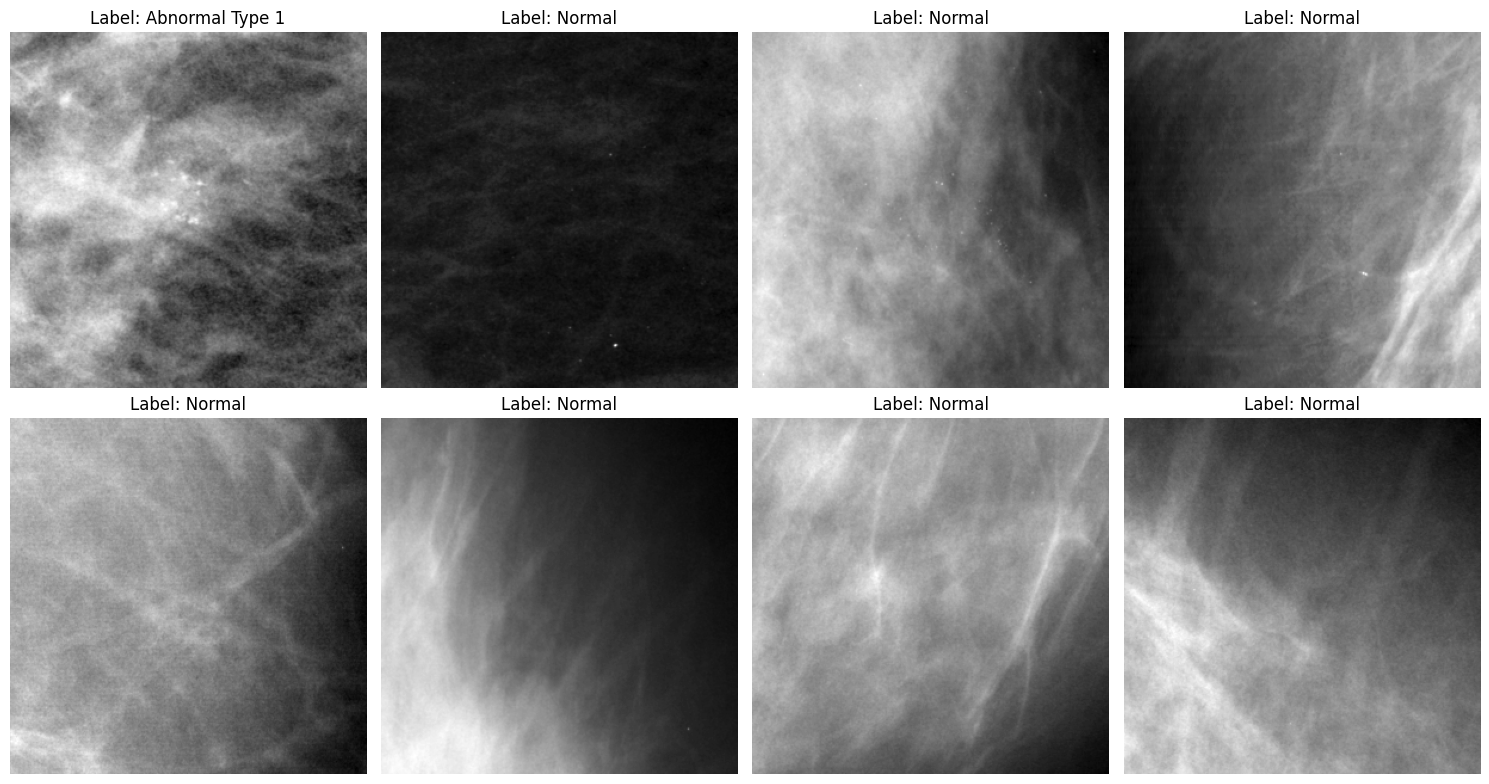

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def display_batch(dataset, num_images=8):
    """
    Display images from a batch of the dataset
    """
    # Get one batch
    for images, labels in dataset.take(1):
        plt.figure(figsize=(15, 8))

        # Display up to num_images from the batch
        for i in range(min(num_images, len(images))):
            plt.subplot(2, 4, i + 1)

            # Convert tensor to numpy and display
            img = images[i].numpy()
            label = np.argmax(labels[i].numpy())

            # Map label index to class name
            label_names = ['Normal', 'Abnormal Type 1', 'Abnormal Type 2',
                         'Abnormal Type 3', 'Abnormal Type 4']
            title = f'Label: {label_names[label]}'

            plt.imshow(img, cmap='gray')
            plt.title(title)
            plt.axis('off')

        plt.tight_layout()
        plt.show()

# Display images from your dataset
display_batch(train_dataset)

# To display multiple batches, you can use:
#for batch in train_dataset.take(10):
#    display_batch(train_dataset)

In [12]:
#Validation et Test Data needs to be combined to mix Masses and Calcifications
print("Loading and combining validation/test data...")
test_data = np.load('/content/test10_data/test10_data.npy', mmap_mode='r')
test_labels = np.load('/content/test10_labels.npy', mmap_mode='r')

cv_data = np.load('/content/cv10_data/cv10_data.npy', mmap_mode='r')
cv_labels = np.load('/content/cv10_labels.npy', mmap_mode='r')

combined_data = np.concatenate([test_data, cv_data])
combined_labels = np.concatenate([test_labels, cv_labels])

#Shuffling the Data
#np.random.shuffle(combined_data)
indices = np.random.permutation(len(combined_data))
combined_data = combined_data[indices]
combined_labels = combined_labels[indices]

Loading and combining validation/test data...


In [13]:
val_split = int(len(combined_data) * 0.5)
val_dataset = create_numpy_dataset(
    combined_data[:val_split],
    combined_labels[:val_split],
    BATCH_SIZE,
    is_training=False
)

test_dataset = create_numpy_dataset(
    combined_data[val_split:],
    combined_labels[val_split:],
    BATCH_SIZE,
    is_training=False
)

class_names = ['Negative', 'Benign Calcification', 'Benign Mass',
               'Malignant Calcification', 'Malignant Mass']

print(train_dataset.take(1))
print(val_dataset.take(2))

def print_label_distribution(labels):
    unique, counts = np.unique(labels, return_counts=True)
    dist = dict(zip(unique, counts))
    print("\nLabel distribution:")
    for label_idx, count in dist.items():
        print(f"{class_names[label_idx]}: {count} samples ({count/len(labels)*100:.2f}%)")

print("\nValidation set:")
print_label_distribution(combined_labels[:val_split])
print("\nTest set:")
print_label_distribution(combined_labels[val_split:])

<_TakeDataset element_spec=(TensorSpec(shape=(None, 299, 299, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>
<_TakeDataset element_spec=(TensorSpec(shape=(None, 299, 299, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

Validation set:

Label distribution:
Negative: 6718 samples (87.45%)
Benign Calcification: 268 samples (3.49%)
Benign Mass: 316 samples (4.11%)
Malignant Calcification: 183 samples (2.38%)
Malignant Mass: 197 samples (2.56%)

Test set:

Label distribution:
Negative: 6642 samples (86.46%)
Benign Calcification: 290 samples (3.78%)
Benign Mass: 326 samples (4.24%)
Malignant Calcification: 186 samples (2.42%)
Malignant Mass: 238 samples (3.10%)


In [14]:
def calculate_class_weights(train_dataset, strategy='basic'):
    """
    Calculate class weights with advanced boosting strategies for minority classes
    """
    class_counts = np.zeros(5)
    total_samples = 0

    # Count samples per class
    for _, labels in train_dataset:
        batch_labels = labels.numpy()
        class_counts += np.sum(batch_labels, axis=0)
        total_samples += len(batch_labels)

    # Calculate base frequencies
    epsilon = 1e-7
    class_frequencies = class_counts / total_samples

    if strategy == 'basic':
        # Original inverse frequency weighting
        class_weights = 1 / (class_frequencies + epsilon)
    elif strategy == 'custom':
        class_weights = 1 / (class_frequencies + epsilon)

        boost_factors = np.array([
            1.0,    # Normal - no boost needed
            2.0,    # Benign Calc - significant boost
            1.8,    # Benign Mass - moderate boost
            2.5,    # Malignant Calc - highest boost (critical class)
            2.0     # Malignant Mass - significant boost
        ])

        class_weights = class_weights * boost_factors

    # Handle zero-count classes
    class_weights[class_counts == 0] = 0.0

    # Normalize weights
    if np.sum(class_weights) > 0:
        class_weights = class_weights * len(class_counts) / np.sum(class_weights)

        # Ensure minimum weight is 1.0
        min_weight = np.min(class_weights[class_weights > 0])
        class_weights = class_weights / min_weight

    class_weights_dict = dict(enumerate(class_weights))

    # Print detailed statistics
    print("\nDataset Statistics:")
    print(f"Total samples: {total_samples}")
    print("\nClass Distribution:")
    label_names = ['Normal', 'Benign Calc', 'Benign Mass',
                   'Malignant Calc', 'Malignant Mass']

    print("\nDetailed Class Analysis:")
    print(f"{'Class':<15} {'Count':>8} {'Frequency':>12} {'Weight':>10}")
    print("-" * 45)

    for i, (count, freq, weight) in enumerate(zip(class_counts,
                                                class_frequencies,
                                                class_weights)):
        print(f"{label_names[i]:<15} {int(count):8d} {freq:12.4f} {weight:10.4f}")

    print("\nWeight Statistics:")
    print(f"Mean weight: {np.mean(class_weights):.4f}")
    print(f"Max/Min ratio: {np.max(class_weights)/np.min(class_weights[class_weights>0]):.4f}")

    return class_weights_dict

class_weights = calculate_class_weights(train_dataset, strategy='custom')


Dataset Statistics:
Total samples: 55885

Class Distribution:

Detailed Class Analysis:
Class              Count    Frequency     Weight
---------------------------------------------
Normal             48490       0.8677     1.0000
Benign Calc         2210       0.0395    43.8822
Benign Mass         1900       0.0340    45.9378
Malignant Calc      1480       0.0265    81.9085
Malignant Mass      1805       0.0323    53.7284

Weight Statistics:
Mean weight: 45.2914
Max/Min ratio: 81.9085


In [15]:
def create_custom_efficientnet(img_size=IMG_SIZE, num_classes=5):
    """
    Creates a custom EfficientNet model for breast imaging classification
    with additional regularization and custom top layers.
    """
    # Load the base EfficientNetB0 model without top layers
    base_model = tf.keras.applications.EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=(img_size, img_size, 3)
    )

    # Convert single channel input to 3 channels
    inputs = tf.keras.Input(shape=(img_size, img_size, 1))
    #x = data_augmentation(inputs)
    x = tf.keras.layers.Conv2D(3, (1, 1), padding='same')(inputs)

    # Pass through EfficientNet base
    x = base_model(x)

    # Custom top layers with similar structure to your original model
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # First dense block
    x = tf.keras.layers.Dense(512, activation='leaky_relu',
                            kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    # Second dense block
    x = tf.keras.layers.Dense(256, activation='leaky_relu',
                            kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    # Output layer
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    # Create model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

In [16]:
def compile_and_prepare_model(model):
    # Learning rate schedule
    initial_learning_rate = 5e-4
    decay_steps = 1000
    decay_rate = 0.9

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=decay_steps,
        decay_rate=decay_rate,
        staircase=True
    )

    # Optimizer with weight decay
    optimizer = tf.keras.optimizers.AdamW(
        learning_rate=initial_learning_rate,
        weight_decay=0.01
    )

    # Compile model
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
            tf.keras.metrics.AUC()
        ]
    )

    return model

In [17]:
model = create_custom_efficientnet()
model = compile_and_prepare_model(model)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 299, 299, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 299, 299, 3)         │               6 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 10, 10, 1280)        │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,841,134 (18.47 MB)

 Trainable params: 4,797,575 (18.30 MB)

 Non-trainable params: 43,559 (170.16 KB)

In [19]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,                  # Number of epochs with no improvement after which training will be stopped
    min_delta=1e-7,              # Minimum change in the monitored quantity to be considered an improvement
    restore_best_weights=True,
)

plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,           # Factor by which the learning rate will be reduced (new_lr = lr * factor)
    patience=5,
    min_delta=1e-7,
    cooldown=0,           # Number of epochs to wait before resuming normal operation after learning rate reduction
    verbose=1
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [ ]:
history = model.fit(train_dataset,
    validation_data=val_dataset,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    class_weight=class_weights,
    callbacks=[early_stopping, plateau, model_checkpoint])

Epoch 1/100
    874/Unknown 574s 523ms/step - accuracy: 0.4102 - auc: 0.6594 - loss: 22.3394 - precision: 0.5304 - recall: 0.3060

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 1: val_loss improved from inf to 9.41231, saving model to best_model.keras
874/874 ━━━━━━━━━━━━━━━━━━━━ 618s 574ms/step - accuracy: 0.4103 - auc: 0.6595 - loss: 22.3354 - precision: 0.5305 - recall: 0.3061 - val_accuracy: 0.4388 - val_auc: 0.7865 - val_loss: 9.4123 - val_precision: 0.4805 - val_recall: 0.3414 - learning_rate: 5.0000e-04
Epoch 2/100
874/874 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.7779 - auc: 0.9304 - loss: 11.7743 - precision: 0.8317 - recall: 0.7237
Epoch 2: val_loss improved from 9.41231 to 5.54110, saving model to best_model.keras
874/874 ━━━━━━━━━━━━━━━━━━━━ 476s 496ms/step - accuracy: 0.7779 - auc: 0.9304 - loss: 11.7721 - precision: 0.8317 - recall: 0.7238 - val_accuracy: 0.7899 - val_auc: 0.9243 - val_loss: 5.5411 - val_precision: 0.8074 - val_recall: 0.7644 - learning_rate: 5.0000e-04
Epoch 3/100
874/874 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.8751 - auc: 0.9731 - loss: 6.0690 - precision: 0.8913 - recall: 0.8599
Epoch 3: val_loss improv